In [1]:
bodies = dict()
with open("/home/xstefan3/bert_experiments/pytorch/cc/crawl/body_aggregated.txt", "r") as bodies_f:
    for line in bodies_f.readlines():
        linestart_str = line.split("\t")[0].replace(" ", "").replace("\t", "").strip()
        try:
            i = int(linestart_str)
            bodies[i] = "\n".join(line.split("\t")[1:])
        except ValueError:
            # entry contains '\n' - still belongs to the previous entry
            try:
                bodies[i] += "\n%s" % line   
            except (KeyError, NameError):
                print("Line '%s' can not be parsed. Skipping." % line)

Line '
' can not be parsed. Skipping.


In [2]:
import pandas as pd
bodies_s = pd.Series(bodies)

In [3]:
import pandas as pd
df = pd.read_csv("/home/xstefan3/bert_experiments/pytorch/cc/crawl/news_aggregator/newsCorpora.csv", 
                 sep="\t", names=["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"])
df = df.set_index("ID", drop=True)
# limit to the already crawled content
df = df.loc[bodies_s.index]
df["content"] = bodies_s

/home/xstefan3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


In [4]:
import nltk
nltk.download('punkt')
sent_splitter = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /home/xstefan3/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# sentences dataframe
from functools import reduce

def sents_series_from_df(df_sub):
    sents = df_sub["content"].apply(sent_splitter.tokenize)
    sents_pairs = [[sent, [i]*len(sent)] for i, sent in zip(sents.index, sents)] 
    # df_sents = pd.DataFrame([df_sub["content"].apply(sent_splitter.tokenize).values, df_sub.index.values]).transpose()
    # df_sents.apply(lambda row: row.apply(), axis=1)
    sents_df = pd.DataFrame(reduce(lambda old, tup: [old[0]+tup[0], old[1]+tup[1]], sents_pairs, [[], []])).transpose()
    sents_df.columns = ["sentence", "doc"]
    return sents_df

## Experiment \#1: Embeddings contextualization

We presume that the same noun and verb in the same context have embeddings significantly more similar than in different contexts

In [6]:
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.modules.token_embedders import ElmoTokenEmbedder

elmo_embedder = ElmoTokenEmbedder(options_file="/home/xstefan3/bert_experiments/pytorch/cc/semantic-role-labeling/SemBERT/models/srl_model_dir/fta/model.text_field_embedder.elmo.options_file", \
                                  weight_file="/home/xstefan3/bert_experiments/pytorch/cc/semantic-role-labeling/SemBERT/models/srl_model_dir/fta/model.text_field_embedder.elmo.weight_file")
word_embeddings = BasicTextFieldEmbedder({"tokens": elmo_embedder})

In [7]:
from allennlp.data.tokenizers.spacy_tokenizer import SpacyTokenizer
tokenizer = SpacyTokenizer()
sents_df =  sents_series_from_df(df[df["STORY"] == "ddUyU0VZz0BRneMioxUPQVP6sIxvM"])
sentences_tokenized = sents_df["sentence"].apply(tokenizer.tokenize).apply(lambda ts: [t.text for t in ts])
sentences_tokenized.iloc[0].__len__()

35

In [8]:
# elmo embedder prototype
from allennlp.modules.elmo import Elmo, batch_to_ids
from allennlp.modules.token_embedders import ElmoTokenEmbedder
from allennlp.data.tokenizers import Tokenizer

character_ids = batch_to_ids(sents_df["sentence"].apply(str.split).iloc[0]).to("cuda")

elmo = ElmoTokenEmbedder(options_file="/home/xstefan3/bert_experiments/pytorch/cc/semantic-role-labeling/SemBERT/models/srl_model_dir/fta/model.text_field_embedder.elmo.options_file", \
                         weight_file="/home/xstefan3/bert_experiments/pytorch/cc/semantic-role-labeling/SemBERT/models/srl_model_dir/fta/model.text_field_embedder.elmo.weight_file")
elmo = elmo.to("cuda")
embeddings = elmo(character_ids)

In [252]:
bert_embedding_for_word("Let's see all hidden-states and attentions on this little text", "attention").shape

(1, 768)

In [208]:
from transformers.tokenization_bert import BertTokenizer
from transformers.modeling_bert import BertModel

sentences = pd.Series(["Hello, my dog is cute", "Also, my cat is cute, but just a bit."])

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
encoded_str = sentences.apply(tokenizer.encode)
sentence_tokenized = encoded_str.apply(tokenizer.convert_ids_to_tokens)
input_ids = torch.tensor([tokenizer.encode("Let's see all hidden-states and attentions on this text")])
outputs = model(input_ids)
last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple
last_hidden_states.shape, sentence_tokenized

(torch.Size([1, 16, 768]),
 0          [[CLS], hello, ,, my, dog, is, cute, [SEP]]
 1    [[CLS], also, ,, my, cat, is, cute, ,, but, ju...
 dtype: object)

In [189]:
tokenizer.encode(["Hello, my dog is cute", "Also, my cat is cute, but just a bit."])

[101, 100, 100, 102]

In [187]:
tokenizer.build_inputs_with_special_tokens(encoded_str).apply(list.__len__)

0    10
1    16
dtype: int64

In [ ]:
class BertEmbedder(BertModel):
    def __init__(model_name='bert-base-uncased'):
        super(self, model_name)
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        
    def __call__(self, sentences: list):
        encoded_str = tokenizer.encode(sentences)
        sentence_tokenized = tokenizer.convert_ids_to_tokens(encoded_str)
        input_ids = torch.tensor(encoded_str).unsqueeze(0)

#### Story selection

In [31]:
df["STORY"].unique()

array(['ddUyU0VZz0BRneMioxUPQVP6sIxvM', 'dPhGU51DcrolUIMxbRm0InaHGA2XM',
       'dxyGGb4iN9Cs9aMZTKQpJeoiQfruM', ...,
       'dydYiv0wtScnuDM-75yG_JgQcM6hM', 'dsvoMlrOmVIVZzMM0Ima1lhrDTg_M',
       'dDk2Wxf1qj2LqAM-yKinrObYASKoM'], dtype=object)

In [400]:
df_sub = df[df["STORY"] == "dsvoMlrOmVIVZzMM0Ima1lhrDTg_M"]
inner_sents_df = sents_series_from_df(df_sub)
inner_sents_df.__len__()

125

In [396]:
# df_sub2 = df[df["STORY"] != "dsvoMlrOmVIVZzMM0Ima1lhrDTg_M"].sample(500)
df_sub2 = df[df["STORY"] == "dPhGU51DcrolUIMxbRm0InaHGA2XM"]
outer_sents_df = sents_series_from_df(df_sub2)
outer_sents_df.__len__()

753

#### Pick ambiguous NN word and inspect distances of its contextual embeddings

In [401]:
' '.join(inner_sents_df["sentence"]).split("company").__len__()

10

In [398]:
' '.join(outer_sents_df["sentence"]).split("company").__len__()

10

In [409]:
from allennlp.data.tokenizers.spacy_tokenizer import SpacyTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch

tokenizer = SpacyTokenizer()


def embeddings_for_word(in_word, sents_df, model, batched=True, infer_batch=32, device="cuda"):
    sents_all = sents_df["sentence"]
    sents_relevant = sents_all[sents_all.apply(lambda sent: in_word in sent)]
    if len(sents_relevant) == 0:
        raise ValueError("No matches for the word %s in dataframe" % in_word)
    sentences_tokenized = sents_relevant.apply(tokenizer.tokenize).apply(lambda ts: [t.text for t in ts])
    inputs = batch_to_ids(sentences_tokenized)
    if batched and len(sentences_tokenized) > infer_batch:
        embeddings_all = torch.Tensor()
        border_is = list(range(0, len(sentences_tokenized), infer_batch))+[len(sentences_tokenized)]
        for batch_low_i, batch_up_i in ((border_is[i-1], border_is[i]) for i in range(1, len(border_is))):
            i_batch = inputs[batch_low_i:batch_up_i]
            print("%s/%s" % (batch_low_i, len(sentences_tokenized)))
            i_embs = model(i_batch.to(device))
            embeddings_all = torch.cat((embeddings_all, i_embs.detach().cpu()), 0)
    else:
        embeddings_all = elmo(inputs.to(device)).detach().cpu()

    embs_word = []
    for sent, embs in zip(sentences_tokenized, embeddings_all.squeeze().detach().numpy()):
#         print("sent_len: %s, embs_len: %s" % (len(sent), len(embs)))
        embs = [emb for word, emb in zip(sent, embs) if word.lower()==in_word.lower()]
        if embs:
            for emb in embs:
                embs_word.append(emb)
    return embs_word

In [420]:
from transformers.tokenization_bert import BertTokenizer
from transformers.modeling_bert import BertModel

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True).to("cuda")


def bert_embedding(sentence, token, device="cuda"):
    if token in sentence:
        encoded_sent = bert_tokenizer.encode(sentence)
        tokenized_sent = np.array(bert_tokenizer.convert_ids_to_tokens(encoded_sent))
        if any([piece in token or token in piece for piece in tokenized_sent]):
            input_ids = torch.tensor([bert_tokenizer.encode(sentence)]).to(device)
            embeddings = bert_model(input_ids)[-1][0][0]
            filter_mask = [(piece in token and len(piece) > len(token)-1 or (token in piece and len(token)) > len(piece)-1) for piece in tokenized_sent]
            token_e = embeddings[filter_mask]
            return tokenized_sent[filter_mask], token_e
        else:
            raise ValueError("No matches for the wordpiece '%s' in dataframe. Present wordpieces: %s" % (token, tokenized_sent))

In [421]:
def bert_embeddings_for_word(in_word, sents_df, device="cuda"):
    sents_all = sents_df["sentence"]
    sents_relevant = sents_all[sents_all.apply(lambda sent: in_word in sent)]
    if len(sents_relevant) == 0:
        raise ValueError("No matches for the word %s in dataframe" % in_word)
    embeddings_all = torch.Tensor().to(device)
    found_tokens = []
    for i, sent in enumerate(sents_relevant):
        output = bert_embedding(sent, in_word, device)
        if output is None:
            continue
        new_tokens, i_embs = output
        found_tokens.extend(new_tokens)
        embeddings_all = torch.cat((embeddings_all, i_embs), 0)
    print(found_tokens)
    return embeddings_all.detach().cpu()

In [422]:
from sklearn.metrics.pairwise import cosine_similarity


def plot_dists(word, embeddings="bert", inter_frame=False, bins=100, subsample=False):
    if embeddings=="bert":
        inner_embs = bert_embeddings_for_word(word, inner_sents_df)
        outer_embs = bert_embeddings_for_word(word, outer_sents_df)
    else:
        inner_embs = embeddings_for_word(word, inner_sents_df, elmo, infer_batch=128)
        outer_embs = embeddings_for_word(word, outer_sents_df, elmo, infer_batch=16)
    if inter_frame:
        inner_dists = 1-cosine_similarity(inner_embs)
        outer_dists = 1-cosine_similarity(inner_embs, outer_embs)
    else:
        inner_dists = 1-cosine_similarity(inner_embs)
        outer_dists = 1-cosine_similarity(outer_embs)
    print(inner_dists.flatten().mean(), outer_dists.flatten().mean())
    from scipy.stats import ttest_ind
    t, pval = ttest_ind(inner_dists.flatten(), outer_dists.flatten())
    print("P-value: %s" % pval)
    if pval < 0.05:
        print("Means are significantly different")
    ax = pd.Series(inner_dists.flatten()).hist(bins=bins, alpha=0.4)
    if subsample:
        pd.Series(outer_dists.flatten()).sample(len(inner_dists.flatten())).reset_index(drop=True).hist(bins=bins, alpha=0.4, ax=ax)
    else:
        pd.Series(outer_dists.flatten()).hist(bins=bins, alpha=0.4, ax=ax)

0/55
16/55
32/55
48/55
0.64832294 0.6522623
P-value: 0.7269603438649522


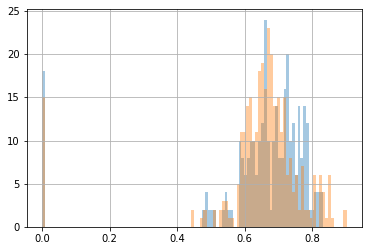

In [376]:
plot_dists('makers', 'elmo', subsample=True)

['makers', 'makers', 'makers', 'make', 'makers', 'makers', 'makers', 'makers', 'makers', 'makers', 'makers', 'makers', 'makers', 'makers', 'makers', 'makers', 'makers', 'makers', 'makers', 'make']
['filmmakers', 'makers', 'makers', '##makers', 'makers', '##makers', 'makers', 'make', 'makers', '##makers', 'makers', 'makers', 'filmmakers', 'filmmakers', 'filmmakers', '##makers', '##makers', '##makers', '##makers', 'makers', 'makers', 'makers', 'makers', 'makers', '##makers', '##makers', '##makers', 'makers', '##makers', 'makers', 'make', 'makers', '##makers', '##makers', 'makers', '##makers', 'makers', 'makers', 'makers', '##makers', '##makers', 'makers', '##makers', '##makers', '##makers', '##makers', '##makers', '##makers', '##makers', '##makers', 'makers', 'makers', 'makers', '##makers', 'makers', 'make', '##makers', '##makers', '##makers', '##makers']
0.1875917 0.3798397
P-value: 1.2992065836089144e-37
Means are significantly different


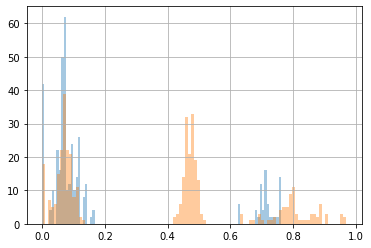

In [377]:
plot_dists('makers', 'bert', subsample=True)

In [95]:
' '.join(inner_sents_df["sentence"])

'General Mills in fight to block Cinnamon Toast Crunch vaping\nOwners of brands geared to children have set the battle lines in a fight to keep names like Thin Mint, Tootsie Roll and Cinnamon Toast Crunch off flavored nicotine used in electronic cigarettes. The Associated Press reports that Golden Valley-based General Mills is joining with the Girl Scouts and Tootsie Roll Industries in firing off cease-and-desist letters to makers of liquid nicotine. The letters demand that they stop using the brands and warn of additional legal action. A trend story published earlier this year by the Oakland Tribune looked at the growing popularity of vaping — puffing on inhalers known as electronic cigarettes or vape pen that use small batteries to heat a flavored liquid until it produces an inhalable vapor. The liquid may contain varying levels of a nicotine kick, from zero (flavor only) up to 24 milligrams, but no tobacco smoke is produced.There are vape shops, vape meets and even Vape Magazine for

In [402]:
' '.join(inner_sents_df["sentence"]).split("company").__len__()

10

In [403]:
' '.join(outer_sents_df["sentence"]).split("company").__len__()

10

0.55156124 0.7286881
P-value: 3.568013155165306e-10
Means are significantly different


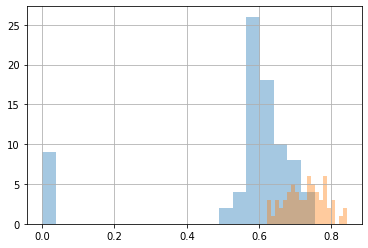

In [414]:
plot_dists("company", "elmo", inter_frame=True, bins=20)

['company', 'company', 'company', 'company', 'company', 'company', 'company', 'company', 'company']
['company', 'company', 'company', 'company', 'company', 'company', 'company', 'company']
0.074598946 0.087819986
P-value: 0.03393970878115804
Means are significantly different


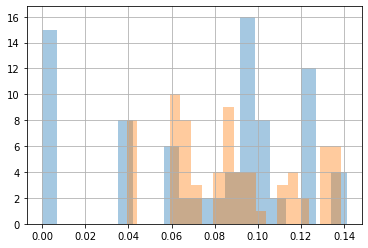

In [423]:
plot_dists("company", "bert", inter_frame=True, bins=20)

0/50
16/50
32/50
48/50
0.7146142 0.7728584
P-value: 1.4896936007605273e-14
Means are significantly different


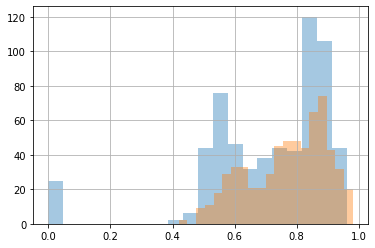

In [425]:
plot_dists("said", "elmo", inter_frame=True, bins=20, subsample=True)

['said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said']
['said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said', 'said']
0.112746835 0.12225543
P-value: 1.0006294730805586e-06
Means are significantly different


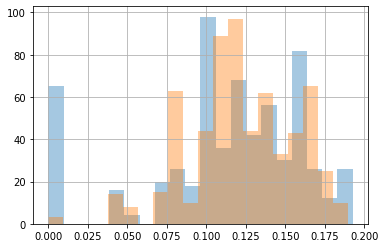

In [426]:
plot_dists("said", "bert", inter_frame=True, bins=20, subsample=True)

## Experiment \#2: inspect Sequential distance:

Sequences of (NN, Major V:(Minor V1, Minor V2, Minor V3))

Compare the inner-topic distance to outer-topic distance, of sequences matching on NN. 

In [102]:
pos_predictor = Predictor.from_path("https://s3-us-west-2.amazonaws.com/allennlp/models/biaffine-dependency-parser-ptb-2018.08.23.tar.gz")


100%|██████████| 73228310/73228310 [00:14<00:00, 5167516.53B/s]


In [118]:
preds

{'arc_loss': 0.0801580473780632,
 'tag_loss': 0.004435896407812834,
 'loss': 0.08459394425153732,
 'words': ['The',
  'new',
  'biopharma',
  'will',
  'focus',
  'on',
  'diagnosis',
  'and',
  'treatment',
  'of',
  'blood',
  '-',
  'related',
  'conditions',
  'and',
  'chronic',
  'diseases',
  ';',
  'developing',
  'new',
  'drugs',
  'through',
  'both',
  'acquisitions',
  'and',
  'collaborations',
  ';'],
 'pos': ['DT',
  'JJ',
  'NN',
  'MD',
  'VB',
  'IN',
  'NN',
  'CC',
  'NN',
  'IN',
  'NN',
  'HYPH',
  'VBN',
  'NNS',
  'CC',
  'JJ',
  'NNS',
  ':',
  'VBG',
  'JJ',
  'NNS',
  'IN',
  'DT',
  'NNS',
  'CC',
  'NNS',
  '.'],
 'predicted_dependencies': ['det',
  'amod',
  'nsubj',
  'aux',
  'root',
  'prep',
  'pobj',
  'cc',
  'conj',
  'prep',
  'pobj',
  'punct',
  'amod',
  'dep',
  'cc',
  'amod',
  'conj',
  'punct',
  'dep',
  'amod',
  'dobj',
  'prep',
  'preconj',
  'pobj',
  'cc',
  'conj',
  'punct'],
 'predicted_heads': [3,
  3,
  5,
  5,
  0,
  5,
  6,
 

In [ ]:
preds = pos_predictor.predict('The new biopharma will focus on diagnosis and treatment of blood-related conditions and chronic diseases; developing new drugs through both acquisitions and collaborations;') 
tags = preds['pos']
words = preds['words']
list(zip(words, tags))

## Experiment \#3: Separate the embeddings

Do margin the contextual embeddings of the pivoting tokens of distinct topics: 

either using the triplet marginalization, or following the objective of 1/0 distance of same/different topic embeddings

In [5]:
from allennlp.predictors import Predictor
import json

class SRLPredictor():
    def __init__(self, SRL_MODEL_PATH, use_cuda=False):
        # use the model from allennlp for simlicity.
        self.predictor = Predictor.from_path(SRL_MODEL_PATH)
        if use_cuda:
            self.predictor._model = self.predictor._model.cuda()  # this can only support GPU computation

    def predict(self, sent):
        return self.predictor.predict(sentence=sent)

srl_predictor = SRLPredictor("/home/xstefan3/bert_experiments/pytorch/cc/semantic-role-labeling/SemBERT/models/srl_model_dir")
    
def get_tags(tok_text):
    tag_vocab = []
    srl_result = srl_predictor.predict(tok_text)
    sen_verbs = srl_result['verbs']
    sen_words = srl_result['words']

    sent_tags = []
    if len(sen_verbs) == 0:
        sent_tags = [["O"] * len(sen_words)]
    else:
        for ix, verb_tag in enumerate(sen_verbs):
            sent_tag = sen_verbs[ix]['tags']
            for tag in sent_tag:
                if tag not in tag_vocab:
                    tag_vocab.append(tag)
            sent_tags.append(sent_tag)

    return sen_words, sent_tags

In [40]:
sents_df["val_frame"] = sents_df["sentence"].apply(srl_predictor.predict)

In [91]:
sents_df["val_frame"].iloc[1]

{'verbs': [{'verb': 'will',
   'description': 'The new biopharma [V: will] focus on diagnosis and treatment of blood - related conditions and chronic diseases ; developing new drugs through both acquisitions and collaborations ; and building a product pipeline focused on effective new treatments for unmet medical needs .',
   'tags': ['O',
    'O',
    'O',
    'B-V',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O']},
  {'verb': 'focus',
   'description': '[ARG0: The new biopharma] [ARGM-MOD: will] [V: focus] [ARG2: on diagnosis and treatment of blood - related conditions and chronic diseases] ; developing new drugs through both acquisitions and collaborations ; and building a product pipeline focu